In [5]:
import pandas as pd

# Load data from CSV without specifying column names if the CSV includes headers
dataset = pd.read_csv('../modified_dataset.csv', sep=',', encoding='utf-8')

# Convert 'Incidents' column to numeric, coercing errors
dataset['Incidents'] = pd.to_numeric(dataset['Incidents'], errors='coerce')

# Drop any rows that could not be converted to numbers (if there were non-numeric values)
dataset = dataset.dropna(subset=['Incidents'])

# Ensure 'Incidents' column is of integer type
dataset['Incidents'] = dataset['Incidents'].astype(int)

# Remove rows where the 'Incidents' count is 0
dataset = dataset[dataset['Incidents'] > 0]

# Explode the DataFrame to repeat rows based on the 'Incidents' column
repeated_dataset = dataset.loc[dataset.index.repeat(dataset['Incidents'])]

# Drop the 'Incidents' column as it is no longer needed
repeated_dataset.drop(columns=['Incidents'], inplace=True)

# Output the result to check
print(repeated_dataset.head())

# Optionally, save the transformed dataset to a new CSV file
repeated_dataset.to_csv('../expanded_dataset.csv', index=False)


  Gender      Age Type of Injury                Area       Type of Vehicle
0   Mænd  0-17 år         Dræbte  Region Hovedstaden  Almindelig personbil
0   Mænd  0-17 år         Dræbte  Region Hovedstaden  Almindelig personbil
8   Mænd  0-17 år         Dræbte  Region Hovedstaden              Knallert
9   Mænd  0-17 år         Dræbte  Region Hovedstaden                 Cykel
9   Mænd  0-17 år         Dræbte  Region Hovedstaden                 Cykel


Classification Report:
                          precision    recall  f1-score   support

Alvorligt tilskadekomne       0.62      0.82      0.71      1499
                 Dræbte       0.29      0.03      0.05       146
  Lettere tilskadekomne       0.48      0.29      0.36       922

               accuracy                           0.59      2567
              macro avg       0.46      0.38      0.37      2567
           weighted avg       0.55      0.59      0.55      2567

Accuracy Score: 0.5862874951305025


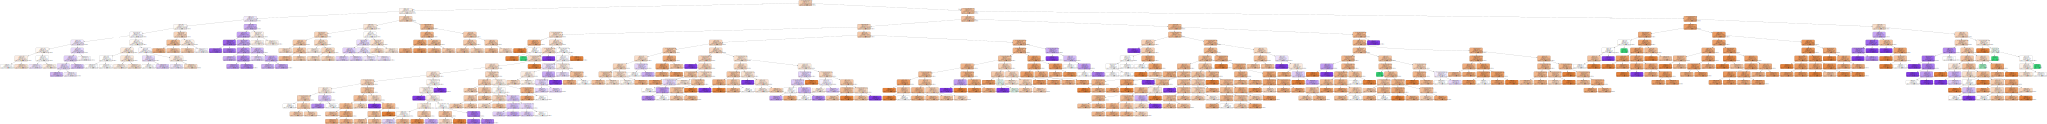

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import graphviz

# Assuming 'repeated_dataset' is already loaded
# Load your data if it's not loaded
# repeated_dataset = pd.read_csv('../expanded_dataset.csv')

# Prepare the data
X = repeated_dataset.drop('Type of Injury', axis=1)
y = repeated_dataset['Type of Injury']

# Encode categorical data
label_encoders = {}
for column in X.columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the decision tree classifier
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X_train, y_train)

# Predictions and Evaluations
y_pred = tree_classifier.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Visualize the decision tree
dot_data = export_graphviz(tree_classifier, out_file=None, 
                           feature_names=X.columns,  
                           class_names=tree_classifier.classes_,
                           filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('decision_tree_improved', format='png')

In [33]:
def predict_injury(gender, age, area, type_of_vehicle):
    # Create a DataFrame for the input features
    input_data = pd.DataFrame({
        'Gender': [gender],
        'Age': [age],
        'Area': [area],
        'Type of Vehicle': [type_of_vehicle]
    })
    
    # Encode the input data using the same label encoders used for training
    for column, le in label_encoders.items():
        input_data[column] = le.transform(input_data[column])
    
    # Make prediction
    prediction = tree_classifier.predict(input_data)
    
    # Get the predicted class label
    predicted_class = prediction[0]
    return predicted_class

# Example usage:
predicted_injury = predict_injury('Kvinder', '18-24 år', 'Region Hovedstaden', 'Almindelig personbil')
print("Predicted Type of Injury:", predicted_injury)


ValueError: y contains previously unseen labels: 'Region Bornholm'

In [23]:
from sklearn.model_selection import GridSearchCV

# Expanded parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15],
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.75]
}

# Grid search with more extensive grid
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid, 
                           cv=5,
                           verbose=2,  # Increase verbosity to see more details during the fitting
                           scoring='accuracy',
                           n_jobs=-1)  # Use all available CPU cores

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Output the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Evaluate on the test set using the best parameters
best_tree = grid_search.best_estimator_
y_pred = best_tree.predict(X_test)
print("Test Accuracy with Best Parameters:", accuracy_score(y_test, y_pred))

# Optionally, visualize the optimized decision tree
dot_data = export_graphviz(best_tree, out_file=None, 
                           feature_names=X.columns,  
                           class_names=best_tree.classes_,
                           filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('decision_tree_more_optimized', format='png')


Fitting 5 folds for each of 1750 candidates, totalling 8750 fits
Best parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2}
Best cross-validation score: 0.62
Test Accuracy with Best Parameters: 0.6073237241916635


'decision_tree_more_optimized.png'

In [28]:
import graphviz
from sklearn.tree import export_graphviz

# Visualize the optimized decision tree
dot_data = export_graphviz(best_tree, out_file=None, 
                           feature_names=X.columns,  
                           class_names=best_tree.classes_,
                           filled=True, rounded=True, special_characters=True)  # Control the size as previously discussed

graph = graphviz.Source(dot_data)
graph_path = graph.render('decision_tree_more_optimized', format='png')
